In [19]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from tqdm.notebook import tqdm
%matplotlib notebook

In [20]:
# Constants
m = 1200.0
g = 9.8
l = 7.0        # Rocket height
lt = 0.8 * l   # Lateral force height
lcg = 0.45 * l # CG height
I = 1/12 * m * l**2

dt = 0.030

maxfN = 12 * m * g
maxfT = 1000

In [21]:
def f(X, U):

    return vertcat(
        X[3],
        X[4],
        X[5],
        U[0] * np.cos(X[2]) / m - U[1] * np.sin(X[2]) / m - g,
        U[0] * np.sin(X[2]) / m + U[1] * np.cos(X[2]) / m,
        U[1] * (lt - lcg) / I
    )

def fnp(X, U):

    return np.array([
        X[3],
        X[4],
        X[5],
        U[0] * np.cos(X[2]) / m - U[1] * np.sin(X[2]) / m - g,
        U[0] * np.sin(X[2]) / m + U[1] * np.cos(X[2]) / m,
        U[1] * (lt - lcg) / I
    ]).T

In [22]:
import scipy

def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.

    dx/dt = A x + B u

    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return K, X, eigVals
 
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.

    x[k+1] = A x[k] + B u[k]

    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*X*B+R)*(B.T*X*A))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return K, X, eigVals

In [23]:
import control

T = 30
N = int(T/dt)

# symbolic state and control
VX = MX.sym('X', 8)
Vf = f(VX[:6], VX[6:])

# Symbolic Jacobian
J = Function('J', [VX], [jacobian(Vf, VX)])

# Initial state at 500,100 with 20 degree tilt
state = np.array([500, 100, np.deg2rad(20), 0, 0, 0], dtype=np.float).T

prev_state = state.copy()

# Reference state
ref = np.array([0, 0, 0, 0, 0, 0, m * g, 0])

# Initial controls
U = np.array([m * g, 0]).T

# WEIGHT MATRICES
Q = np.diag([1000, 1, 1, 1000, 1, 0])
R = np.diag([0.01, 0.005])

states = []
controls = []
for i in tqdm(range(N)):
    
    # LINEARIZATION
    # Computing Jacobian
    AB = np.array(J(ref))
    
    # A and B matrices
    A = AB[:, :6]
    B = AB[:, 6:]

    # Copying state before updating
    prev_state = state.copy()
    
    # Calculating control
    K, _, _ = lqr(A, B, Q, R)
    
    du = -K @ (state - ref[:6])  # du = - K @ dx
    du = np.array(du).flatten()
    
    U += np.array(du)
    
    # Control saturation
    if U[0] < 0:
        U[0] = 0
    if U[0] > maxfN:
        U[0] = maxfN
        
    if U[1] < -maxfT:
        U[1] = -maxfT
    if U[1] > maxfT:
        U[1] = maxfT
    
    # Applying controls to the non-linear system
    state += fnp(state, U) * dt
    
    states.append(state.copy())
    controls.append(U.copy())
    
states = np.array(states)
controls = np.array(controls)

<ipython-input-23-f4d6ff412048>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  state = np.array([500, 100, np.deg2rad(20), 0, 0, 0], dtype=np.float).T


<IPython.core.display.Javascript object>


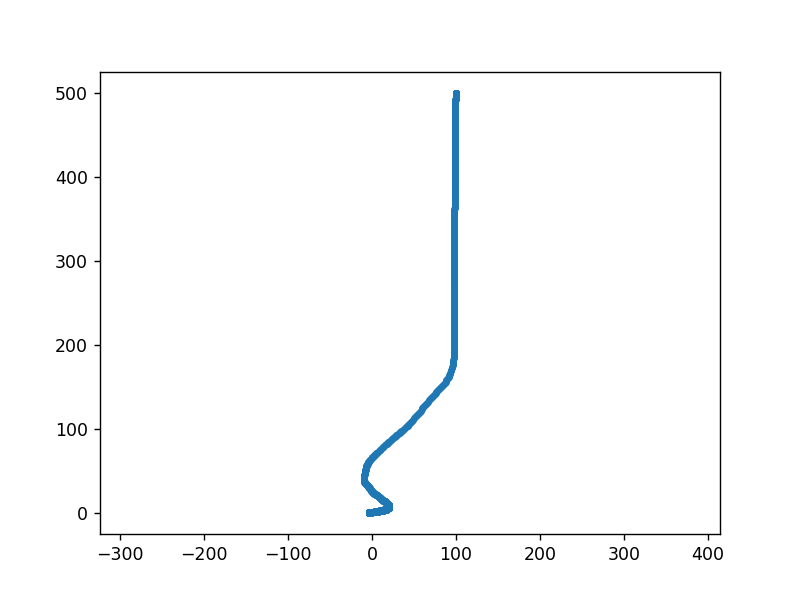

<IPython.core.display.Javascript object>


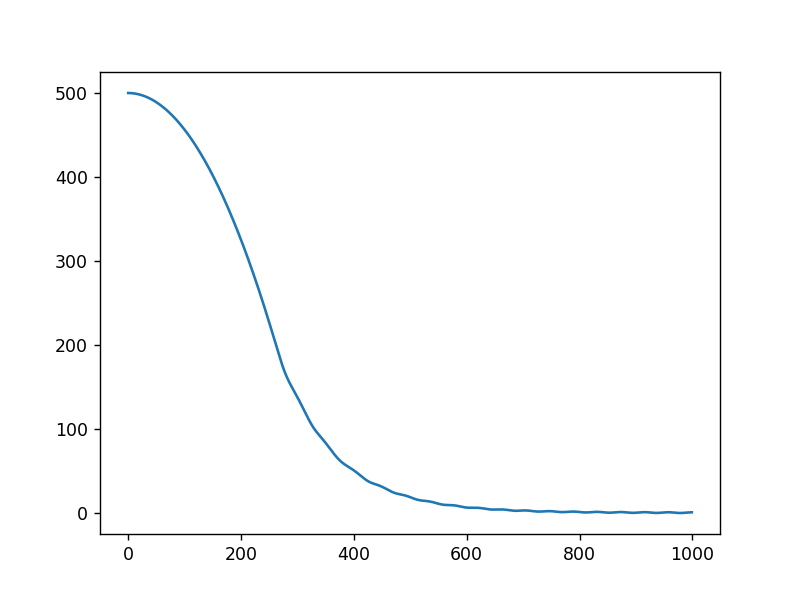

<IPython.core.display.Javascript object>


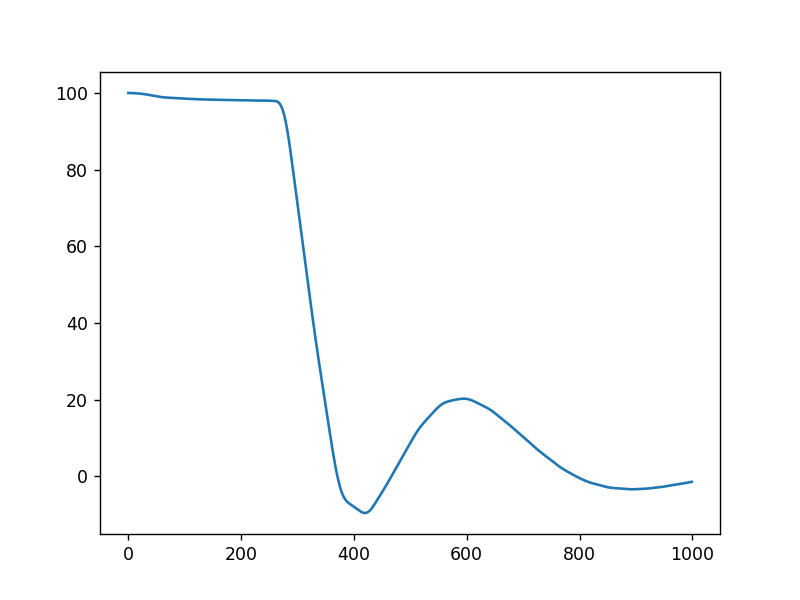

<IPython.core.display.Javascript object>


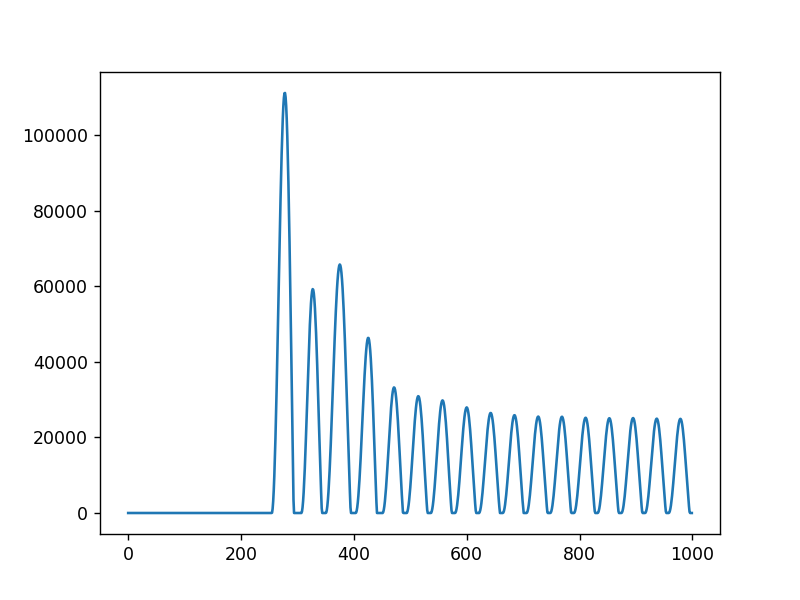

<IPython.core.display.Javascript object>


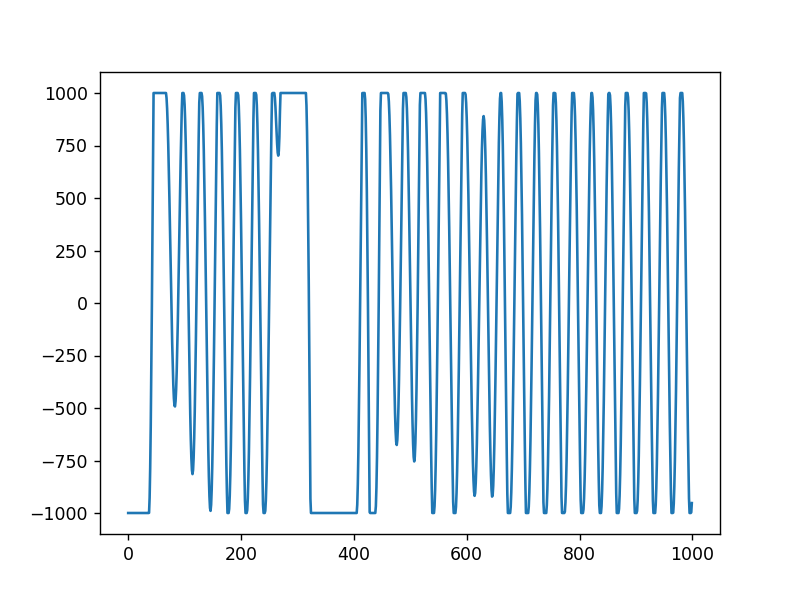

In [25]:
# Plotting
plt.figure("Rocket Trajectory")
plt.plot(states[:, 1], states[:, 0])
plt.scatter(states[:, 1], states[:, 0], marker=".")
plt.axis("equal")

plt.figure("Altitude (Soft Touch-down)")
plt.plot(states[:, 0])

plt.figure("Lateral Motion")
plt.plot(states[:, 1])

plt.figure("Normal Force")
plt.plot(controls[:, 0])

plt.figure("Tangent Force")
plt.plot(controls[:, 1])

plt.show()